In [1]:
import os
from IPython.display import clear_output
os.chdir("./drive/My Drive/Colab Notebooks/SDSProject/MyProject")
os.getcwd()
#os.listdir(".")

'/content/drive/My Drive/Colab Notebooks/SDSProject/MyProject'

In [0]:
%tensorflow_version 1.x
!pip install Scikit-learn==0.19.1
clear_output()

In [3]:
import numpy as np
import imageio
import time, os, math, re, random, io, collections
import pandas as pd
import matplotlib.pyplot as plt
import keras
from itertools import chain
from keras.models import Model
from keras.utils import np_utils
from keras import regularizers
from keras.preprocessing import sequence
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.


In [0]:
def getExpertiseLevelOfSurgery(surgery_name):
	## function getMetaDataForSurgeries should be already called
	if surgeries_metadata.__contains__(surgery_name):
		return surgeries_metadata[surgery_name][0]
	return None 

def getMetaDataForSurgeries(surgery_type):
	surgeries_metadata = {}
	file = open(root_dir+surgery_type+'/'+'meta_file_'+surgery_type+'.txt','r')
	for line in file: 
		line = line.strip() ## remove spaces
	
		if len(line)==0: ## if end of file
			break
	
		b = line.split()
		surgery_name = b[0] 
		expertise_level = b[1]
		b = b[2:]
		scores = [int(e) for e in b]
		surgeries_metadata[surgery_name]=(expertise_level,scores)
	return surgeries_metadata

def fit_encoder(y_train,y_test,y_val): 
	y_train_test_val = y_train+y_test+y_val
	encoder.fit(y_train_test_val)

def convertStringClassesToBinaryClasses(y_train,y_test,y_val):
	idx_y_test = len(y_train)
	idx_y_val = len(y_train)+len(y_test)
	y_train_test_val = y_train+y_test+y_val
	y_train_test_val = encoder.transform(y_train_test_val)
	y_train_test_val = np_utils.to_categorical(y_train_test_val)
	y_train = y_train_test_val[0:idx_y_test]
	y_test = y_train_test_val[idx_y_test:idx_y_val]
	y_val = y_train_test_val[idx_y_val:]
	return y_train,y_test,y_val

def get_trial_num(surgery_name,surgery_type):
	trial_num = surgery_name.replace(surgery_type+'_',"")[-1]
	return trial_num

def readFile(file_name,dtype,columns_to_use=None):
	X = np.loadtxt(file_name,dtype,usecols=columns_to_use)
	return X

def generateMaps(surgery_type):
	listOfSurgeries =[]
	y =[]
	path = root_dir+surgery_type+'/kinematics/AllGestures/'
	for subdir,dirs,files in os.walk(path):
		for file_name in files: 
			surgery = readFile(path+file_name,float,columns_to_use=dimensions_to_use)
			surgery_name = file_name[:-4]
			expertise_level = getExpertiseLevelOfSurgery(surgery_name)
			if expertise_level is None: 
				continue
			mapSurgeryDataBySurgeryName[surgery_name] = surgery
			mapExpertiseLevelBySurgeryName[surgery_name] = expertise_level
	return None


def write_csv_string_in_file(file_name,csv_string):
	file = open(path_to_results+ file_name + '.csv','w')
	file.write(csv_string)
	file.close()
	return True

# shuffles train and labels 
def shuffle(x_train,y_train):
	y_train = np.array(y_train)
	y_train = y_train.reshape(len(y_train),1)
	x_train = x_train.reshape(len(x_train),1)
	x_y_train = np.concatenate((x_train,y_train), axis=1)
	np.random.shuffle(x_y_train)
	return x_y_train[:,0] , x_y_train[:,1].tolist()
'''
#-------------------------------------------------------#
#---------------User out validation---------------------#
#-------------------------------------------------------#
def validation(surgery_type = 'Suturing' , summary=False, reg =0.01, max_itr=20):
	# reg is the regularization parameter 
	# max_itr is the number of iterations to repeat the experiments
	counter = 0
  #UserOut & SuperTrialOut
	path = path_to_configurations+surgery_type +'/'+'unBalanced'+'/'+'GestureClassification'+'/'+'UserOut'
	results = "fold,iteration,macro,micro\n"
	for it in range(0,max_itr):
		for subdir,dirs,files in os.walk(path):
			# One configuration with two files Train.txt and Test.txt
			x_train = []
			y_train = []
			x_test = []
			y_test = []
			x_val = []
			y_val = []
			trial_added_to_val = None
			min_length_train = np.iinfo(np.int32).max # this is the minimum length of a training instance
			min_length_test = np.iinfo(np.int32).max # this is the minimum length of a test instance
			min_length_val = np.iinfo(np.int32).max # this is the minimum length of a val instance
			for file_name in files:
				data = readFile(subdir+'/'+file_name,str)
				surgeries_set = set()
				for gesture in data:
					surgery_name = find_pattern(gesture[0],surgery_type+'_.00.')
					surgeries_set.add(surgery_name)
	
				for surgery_name in surgeries_set:
					trial_num = get_trial_num(surgery_name,surgery_type)
					if file_name == 'Train.txt':
						if(trial_added_to_val is None):
							trial_added_to_val=trial_num
						
						if(trial_num==trial_added_to_val): 
							# we should add to validation set 
							min_length_val=min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_val)
							x_val.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_val.append(mapExpertiseLevelBySurgeryName[surgery_name])
						else: # we add to the train set 
							min_length_train = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_train)
							x_train.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_train.append(mapExpertiseLevelBySurgeryName[surgery_name])
					else:
						# we are adding to the test set
						min_length_test = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_test)
						x_test.append(mapSurgeryDataBySurgeryName[surgery_name])
						y_test.append(mapExpertiseLevelBySurgeryName[surgery_name])
				# end of one file Train or Test 
			if(len(files)>0):
	
				x_train = np.array(x_train)
				x_test = np.array(x_test)
				x_val = np.array(x_val)
	
				print('train size:'+str(len(x_train)))
				print('val size:'+str(len(x_val)))
				print('test size:'+str(len(x_test)))
	
				fit_encoder(y_train,y_test,y_val)
	
				model = each_dim_build_model(input_shapes,summary=summary,reg =reg)
				
				fold = find_pattern(subdir,'UserOut'+'/.*_Out').replace('UserOut'+'/','').replace('_Out','')
				iteration = find_pattern(subdir, 'itr_.*').replace('itr_','')
				# we train on each training instance 
					
				y_test = fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val)	
					
				model = load_model('LOSO/model.h5')# reload the best model saved 

				# uncomment if you want to visualize the class activiation map as a gif 
				# generate_class_activation_map_for_all_surgeries(model,fold)
				
				# evaluate model and get results for confusion matrix 
				(macro,micro) = evaluateModel(model,x_test,y_test)
				results += fold+','+str(it)+','+str(macro)+','+str(micro)+'\n'
	
			# end of one configuration 
	matrix = confusion_matrix.to_numpy()
	macro = compute_macro(matrix)
	micro = compute_micro(matrix)
	results += 'total,total,'+str(macro)+','+str(micro)+'\n'
	results_file_name = 'results'
	return write_csv_string_in_file(results_file_name,results)
'''
#-------------------------------------------------------#
#-------------Supertrial out validation-----------------#
#-------------------------------------------------------#
def validation(surgery_type = 'Suturing' , summary=False, reg =0.01, max_itr=5):
	# reg is the regularization parameter 
	# max_itr is the number of iterations to repeat the experiments
	counter = 0
	path = path_to_configurations+surgery_type +'/'+'unBalanced'+'/'+'GestureClassification'+'/'+'SuperTrialOut'
	results = "fold,iteration,macro,micro\n"
	for it in range(0,max_itr):
		for subdir,dirs,files in os.walk(path):
			# One configuration with two files Train.txt and Test.txt
			x_train = []
			y_train = []
			x_test = []
			y_test = []
			x_val = []
			y_val = []
			trial_added_to_val = None
			min_length_train = np.iinfo(np.int32).max # this is the minimum length of a training instance
			min_length_test = np.iinfo(np.int32).max # this is the minimum length of a test instance
			min_length_val = np.iinfo(np.int32).max # this is the minimum length of a val instance
			for file_name in files:
				data = readFile(subdir+'/'+file_name,str)
				surgeries_set = set()
				for gesture in data:
					surgery_name = find_pattern(gesture[0],surgery_type+'_.00.')
					surgeries_set.add(surgery_name)
	
				for surgery_name in surgeries_set:
					trial_num = get_trial_num(surgery_name,surgery_type)
					if file_name == 'Train.txt':
						if(trial_added_to_val is None):
							trial_added_to_val=trial_num
						
						if(trial_num==trial_added_to_val): 
							# we should add to validation set 
							min_length_val=min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_val)
							x_val.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_val.append(mapExpertiseLevelBySurgeryName[surgery_name])
						else: # we add to the train set 
							min_length_train = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_train)
							x_train.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_train.append(mapExpertiseLevelBySurgeryName[surgery_name])
					else:
						# we are adding to the test set
						min_length_test = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_test)
						x_test.append(mapSurgeryDataBySurgeryName[surgery_name])
						y_test.append(mapExpertiseLevelBySurgeryName[surgery_name])
				# end of one file Train or Test 
			if(len(files)>0):
	
				x_train = np.array(x_train)
				x_test = np.array(x_test)
				x_val = np.array(x_val)
	
				print('train size:'+str(len(x_train)))
				print('val size:'+str(len(x_val)))
				print('test size:'+str(len(x_test)))
	
	
				fit_encoder(y_train,y_test,y_val)
	
				model = each_dim_build_model(input_shapes,summary=summary,reg =reg)
				
				fold = find_pattern(subdir,'SuperTrialOut'+'/.*_Out').replace('SuperTrialOut'+'/','').replace('_Out','')
				iteration = find_pattern(subdir, 'itr_.*').replace('itr_','')
				# we train on each training instance 
					
				y_test = fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val)	
					
				model = load_model('LOSO/model.h5')# reload the best model saved 

				# uncomment if you want to visualize the class activiation map as a gif 
				# generate_class_activation_map_for_all_surgeries(model,fold)
				
				# evaluate model and get results for confusion matrix 
				(macro,micro) = evaluateModel(model,x_test,y_test)
				results += fold+','+str(it)+','+str(macro)+','+str(micro)+'\n'
	
			# end of one configuration 
	matrix = confusion_matrix.to_numpy()
	macro = compute_macro(matrix)
	micro = compute_micro(matrix)
	results += 'total,total,'+str(macro)+','+str(micro)+'\n'
	results_file_name = 'results'
	return write_csv_string_in_file(results_file_name,results)


def find_pattern(word,pattern):
	return re.search(r''+pattern,word).group(0)

def compute_micro(matrix):
	return sum(matrix.diagonal()) / np.sum(matrix)

def compute_macro(matrix):
	res = matrix.diagonal()/np.sum(matrix,axis=1)
	return np.nansum(res)/float(nb_classes)

def fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val):
	# x_test and y_test are used to monitor the overfitting / underfitting not for training 
	# minimum epoch loss on val set
	min_val_loss =  np.iinfo(np.int32).max 
	# train for many epochs as specified by nb_epochs
	for epoch in range(0,nb_epochs) : 
		# shuffle before every epoch training 
		x_train,y_train=shuffle(x_train,y_train)
		#convert string labels to binary forms
		y_train_binary,y_test_binary,y_val_binary = convertStringClassesToBinaryClasses(y_train,y_test,y_val)
		# train each sequence alone
		epoch_val_loss = 0
		for sequence,label in zip(x_train,y_train_binary):
			model.train_on_batch(split_input_for_training(sequence),label.reshape(1,nb_classes))
			
		epoch_tra_loss = evaluate_for_epoch(model,x_train,y_train_binary)
		epoch_val_loss = evaluate_for_epoch(model,x_val,y_val_binary)
		#print(epoch_tra_loss, epoch_val_loss)
		if(epoch_val_loss < min_val_loss): # this is to choose finally the model that yields the best results on the validation set 
			model.save('LOSO/model.h5')
			min_val_loss= epoch_val_loss

	return y_test_binary

def evaluate_for_epoch(model,x_test,y_test):
	epoch_test_loss = 0 
	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		epoch_test_loss += loss ############### change if monitor acc instead of loss
	return epoch_test_loss/len(x_test)

def evaluateModel(model,x_test,y_test):
	confusion_matrix_f = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) 

	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		p = model.predict(split_input_for_training(test), batch_size = 1)
		predicted_integer_label = np.argmax(p).astype(int)
		predicted_label = encoder.inverse_transform(predicted_integer_label)
		correct_label = encoder.inverse_transform(np.argmax(label))
		confusion_matrix[correct_label][predicted_label]+=1.0
		confusion_matrix_f[correct_label][predicted_label]+=1.0

	matrix_f = confusion_matrix_f.to_numpy()
	macro = compute_macro(matrix_f)
	return (macro,compute_micro(matrix_f))

def create_video_feedback(time_series_original,original_binary_class,model,surgery_name,slave_manipulator='Left'):
	path_to_images = path_to_results+'feedback/'
	path_to_video = path_to_results+'feedback/'
	maximum_frames = time_series_original.shape[0]

	# save binary classes for reusing same model and encoder 
	np.save('binary_classes.npy', encoder.classes_)
	
	# generate an image for each frame 
	for i in range(0,maximum_frames): 
		class_activation_map(time_series_original,original_binary_class,model,path_to_images+surgery_name+'__'+str(f'{i:06}')+'.png',max_frame=i+1,slave_manipulator=slave_manipulator,angle=15*6,elev=75+180)
		# angle=15*6,elev=75+180

	# create video from images
	# os.system('ffmpeg -f image2 -r 1/5 -i '+path_to_images+surgery_name+'__%06d.png -vcodec mpeg4 -y '+path_to_video+surgery_name+'_feedback.mp4')
	os.system('ffmpeg -f image2 -framerate 30 -i '+path_to_images+surgery_name+'__%06d.png -s 640x480 '+ path_to_video+surgery_name+slave_manipulator+'.mp4')
	exit() 

def class_activation_map(time_series_original,original_binary_class,model,output_path,max_frame=0,angle=None,slave_manipulator=True,elev=None):
	if max_frame == 0: 
		max_frame=time_series_original.shape[0]

	w_k_c = model.layers[-1].get_weights()[0] # weights for each filter k for each class c 

	new_input_layer = model.inputs # same input of the original model

	new_outpu_layer = [model.get_layer("conv_final").output, model.layers[-1].output] # output is both the original as well as the before last layer 

	new_function = keras.backend.function(new_input_layer,new_outpu_layer)

	new_feed_forward = new_function

	[conv_out, predicted] = new_feed_forward(split_input_for_training(time_series_original))

	# print("original_label: "+str(encoder.inverse_transform(np.argmax(original_binary_class))))
	# print("original_shape: "+str(time_series_original.shape))
	# print("predicted_label:"+str(encoder.inverse_transform(np.argmax(predicted))))
	# print("predicted_shape:"+str(conv_out.shape))

	cas = np.zeros(dtype=np.float, shape = (conv_out.shape[1]))

	conv_out = conv_out[0,:,:]

	# print(np.argmax(original_binary_class))

	for k,w in enumerate(w_k_c[:,np.argmax(original_binary_class)]):
		cas += w * conv_out[:,k]

	minimum = np.min(cas)
	
	cas = cas - minimum

	cas = cas/max(cas)
	cas = cas * 100
	cas = cas.astype(int)

	if slave_manipulator=='Left':# it is the left slave manipulator we want to visualize 
		x_index = 38
		y_index = 39
		z_index = 40
	else: # it is the right slave manipulator we want to visualize 
		x_index = 57
		y_index = 58
		z_index = 59

	max_x_axis = max(time_series_original[:,x_index])
	max_y_axis = max(time_series_original[:,y_index])
	max_z_axis = max(time_series_original[:,z_index])
	min_x_axis = min(time_series_original[:,x_index])
	min_y_axis = min(time_series_original[:,y_index])
	min_z_axis = min(time_series_original[:,z_index])

	x = time_series_original[0:max_frame,x_index]
	y = time_series_original[0:max_frame,y_index]
	z = time_series_original[0:max_frame,z_index]

	cas = cas[0:max_frame]

	# just to have the maximum color 100 and another one with color 0 somwhere in (100,100,100) without appearing on screen
	x=np.concatenate((x,[100],[100]))
	y=np.concatenate((y,[100],[100]))
	z=np.concatenate((z,[100],[100]))
	# here we specify the colors 
	cas = np.concatenate((cas,[100],[0]))

	fig = plt.figure()
	plot3d = fig.add_subplot(111,projection='3d')
	pltmap = plot3d.scatter(x,y,z, c=cas, cmap='jet',s=3)
	ax = plt.gca()
	ax.set_xticklabels([])
	ax.set_yticklabels([])
	ax.set_zticklabels([])
	ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
	ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
	ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
	ax.view_init(elev=elev, azim=angle)
	ax.set_xlim(min_x_axis,max_x_axis)
	ax.set_ylim(min_y_axis,max_y_axis)
	ax.set_zlim(min_z_axis,max_z_axis)
	# Get rid of the spines
	ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
	ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
	ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
	ax.set_xlabel('X' )
	ax.set_ylabel('Y')
	ax.set_zlabel('Z')
	# clbr = plt.colorbar(pltmap)
	# clbr.set_ticks([])
	plt.savefig(output_path)
	plt.close('all')


def generate_class_activation_map_for_all_surgeries(model,fold): 
	
	for surgery_name in mapSurgeryDataBySurgeryName.keys(): 
		# get the time series for this surgery 
		surgery = mapSurgeryDataBySurgeryName[surgery_name]
		# get skill level of the surgeon who performed thi surgery 
		skill = mapExpertiseLevelBySurgeryName[surgery_name]
		# convert string class to binary
		skill = convertStringClassesToBinaryClasses([skill],['N','I','E'],[])[0]
		# print class activation map for this surgery in the pdf file 
		# for every view angle 
		for angle in range(0,60):
			# name the output file
			# output_path = path_to_results+'feedback/'+surgery_type+'/'+str(fold)+'_out/'+surgery_name+'.png'
			output_path = path_to_results+'feedback/img_temp/img_'+str(f'{angle:03}')+'.png'
			# draw 
			class_activation_map(surgery,skill,model,output_path,angle=angle*6)

		# create the gif
		images=[] 
		for subdir,dirs,files in os.walk(path_to_results+'feedback/img_temp/'):
			files.sort()
			for file_name in files:
				images.append(imageio.imread(path_to_results+'feedback/img_temp/'+file_name))
			output_path = path_to_results+'feedback/'+surgery_type+'/'+str(fold)+'_out/'+surgery_name+'.gif'
			kargs = { 'duration': 0.25 }
			imageio.mimsave(output_path,images,'GIF',**kargs)
	return None 


# the sequence variable is the multivariate time series or in this case the surgical task
# we want to split the inputs in order to train  
def split_input_for_training(sequence):
	# get number of hands 
	num_hands= len(input_shapes)
	# get number of dimensions cluster for each hand 
	num_dim_clusters = len(input_shapes[0])
	# define the new input sequence 
	x = []
	# this is used to keep track of the assigned dimensions 
	last = 0
	# loop over each hand 
	for i in range(num_hands):
		# loop for each hand over the cluster of dimensions 
		for j in range(num_dim_clusters): 
			# assign new input same length but different dimensions each time 
			x.append(np.array([sequence[:,last:(last+input_shapes[i][j][1])]]))
			# remember last assigned 
			last= input_shapes[i][j][1]
	# return the new input 
	return x                              

def each_dim_build_model(input_shapes,summary=False, reg=0.00001): 
	# get number of hands 
	num_hands= len(input_shapes)
	# get number of dimensions cluster for each hand 
	num_dim_clusters = len(input_shapes[0])
	# first index for hand second for  dims
	x =[[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# first conv layer on each dim cluster for each hand 
	conv1 = [[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# merged layers for each hand 
	hand_layers =[None for a in range(num_hands)]
	# second conv layer on concatenated conv1 for each hand
	conv2 = [None for a in range(num_hands)] 
	# loop over each hand 
	for i in range(0,num_hands): 
		# loop for each hand over the dimension (or channels) clusters 
		for j in range(0,num_dim_clusters): 
			# input layer for each dimension cluster for each hand 
			x[i][j]=keras.layers.Input(input_shapes[i][j])
			# first conv layer over the clustered dimensions or channels in terms of keras 
			conv1[i][j] = keras.layers.Conv1D(8,kernel_size=3,strides=1,padding='same', activity_regularizer=regularizers.l2(reg))(x[i][j])
			conv1[i][j] = keras.layers.Activation('relu')(conv1[i][j])
		# concatenate convolutions of first layer over the channels dimension for each hand 
		hand_layers[i]=keras.layers.Concatenate(axis=-1)(conv1[i])
		# do a second convolution over features extracted from the first convolution over each hand 
		conv2[i] = keras.layers.Conv1D(16,kernel_size=3, strides=1, padding='same', activity_regularizer=regularizers.l2(reg))(hand_layers[i])
		conv2[i] = keras.layers.Activation('relu')(conv2[i])
	# concatenate the features of the two hands 
	final_input = keras.layers.Concatenate(axis=-1)(conv2) 
	# do a final convolution over the features concatenated for all hands 
	conv3 = keras.layers.Conv1D(32,kernel_size=3,strides=1,padding='same', activity_regularizer = regularizers.l2(reg))(final_input)
	conv3 = keras.layers.Activation('relu', name = "conv_final")(conv3)
	# do a globla average pooling of the final convolution 
	pooled = keras.layers.GlobalAveragePooling1D()(conv3)
	# add the final softmax classifier layer 
	out = keras.layers.Dense(nb_classes,activation='softmax')(pooled)
	# create the model and link input to output 
	model = Model(inputs=list(chain.from_iterable(x)),outputs=out)
	# show summary if specified 
	if summary==True : 
		model.summary()

	# choose the optimizer 
	optimizer = keras.optimizers.Adam()
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

	return model

In [6]:
# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/LOSO/'
nb_epochs = 1000
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Suturing'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name  
classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))


Number of different surgeries in total: 39


In [0]:

#for draw figures
def fitModel_curve(model,x_train,y_train,x_test,y_test,x_val,y_val):
	# x_test and y_test are used to monitor the overfitting / underfitting not for training 
	# minimum epoch loss on val set
	min_val_loss =  np.iinfo(np.int32).max 
	curve_acc = [[],[]]
	curve_loss = [[],[]]
  # train for many epochs as specified by nb_epochs
	for epoch in range(0,nb_epochs) : 
		# shuffle before every epoch training 
		x_train,y_train=shuffle(x_train,y_train)
		#convert string labels to binary forms
		y_train_binary,y_test_binary,y_val_binary = convertStringClassesToBinaryClasses(y_train,y_test,y_val)
		# train each sequence alone
		epoch_val_loss, epoch_val_acc, epoch_tra_loss, epoch_tra_acc = 0, 0, 0, 0
		for sequence,label in zip(x_train,y_train_binary):
			model.train_on_batch(split_input_for_training(sequence),label.reshape(1,nb_classes))
			
		epoch_tra_loss, epoch_tra_acc = evaluate_for_epoch(model,x_train,y_train_binary)
		epoch_val_loss, epoch_val_acc = evaluate_for_epoch(model,x_val,y_val_binary)
		print("acc : t/v", epoch_tra_acc, epoch_val_acc)
		print("loss: t/v", epoch_tra_loss, epoch_val_loss)
		curve_acc[0].append(epoch_tra_acc)
		curve_acc[1].append(epoch_val_acc)
		curve_loss[0].append(epoch_tra_loss)
		curve_loss[1].append(epoch_val_loss)
		if(epoch_val_loss < min_val_loss): # this is to choose finally the model that yields the best results on the validation set 
			model.save('Regroup_LOUO/model.h5')
			min_val_loss= epoch_val_loss
	return y_test_binary, curve_acc, curve_loss

def evaluate_for_epoch(model,x_test,y_test):
	epoch_test_loss, epoch_test_acc = 0, 0
	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		epoch_test_loss += loss ############### change if monitor acc instead of loss
		epoch_test_acc += acc ############### change if monitor acc instead of loss
	return epoch_test_loss/len(x_test), epoch_test_acc/len(x_test)
#For LOUO
def get_name_letter(surgery_name,surgery_type):
	name_letter = surgery_name.replace(surgery_type+'_',"")[-4]
	return name_letter

train size:23
val size:8
test size:8
acc : t/v 0.4782608695652174 0.5
loss: t/v 1.5925469657649165 1.9473727196455002
acc : t/v 0.6521739130434783 0.625
loss: t/v 1.361994769262231 1.6423715353012085
acc : t/v 0.6521739130434783 0.5
loss: t/v 1.2131441468777864 1.4703427702188492
acc : t/v 0.6521739130434783 0.625
loss: t/v 1.106671022332233 1.354113295674324
acc : t/v 0.8260869565217391 0.75
loss: t/v 1.0391509066457334 1.273060604929924
acc : t/v 0.8695652173913043 0.75
loss: t/v 0.9612384775410527 1.2008113637566566
acc : t/v 0.8260869565217391 0.75
loss: t/v 0.8857178584389065 1.1350531429052353
acc : t/v 0.8695652173913043 0.875
loss: t/v 0.8250948786735535 1.070042833685875
acc : t/v 0.9130434782608695 1.0
loss: t/v 0.7884322923162709 1.0271341055631638
acc : t/v 0.9130434782608695 1.0
loss: t/v 0.7168166663335718 0.9663787484169006
acc : t/v 0.9130434782608695 1.0
loss: t/v 0.6651455604511759 0.8939120918512344
acc : t/v 1.0 1.0
loss: t/v 0.6482038251731707 0.8701429590582848
ac

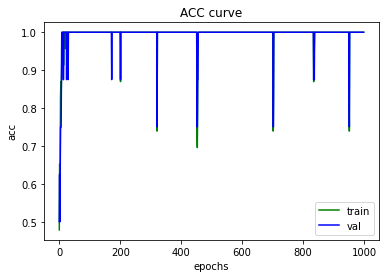

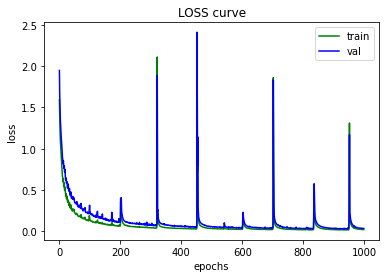

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:23
val size:8
test size:8
acc : t/v 0.4782608695652174 0.5
loss: t/v 1.7308217546214228 2.0081403702497482
acc : t/v 0.4782608695652174 0.5
loss: t/v 1.4780490009681038 1.698216050863266
acc : t/v 0.5652173913043478 0.5
loss: t/v 1.296296521373417 1.4741207361221313
acc : t/v 0.6956521739130435 0.75
loss: t/v 1.2257698826167895 1.3499922305345535
acc : t/v 0.6956521739130435 0.5
loss: t/v 1.0922939932864646 1.2798230722546577
acc : t/v 0.7391304347826086 0.75
loss: t/v 0.9823950658673826 1.1561092883348465
acc : t/v 0.8695652173913043 0.875
loss: t/v 0.9461076078207596 1.0988874807953835
acc : t/v 0.8260869565217391 0.75
loss: t/v 0.8551509471043296 1.0559554249048233
acc : t/v 0.8695652173913043 0.875
loss: t/v 0.7814050731451615 0.951983131468296
acc : t/v 0.8260869565217391 0.875
loss: t/v 0.7403348852758822 0.9155866205692291
acc : t/v 0.9130434782608695 1.0
loss: t/v 0.6868460515271062 0.8482666686177254
acc : t/v 0.9130434782608695 1.0
loss: t/v 0.6497678018134573 0.80

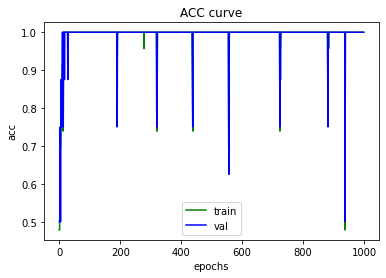

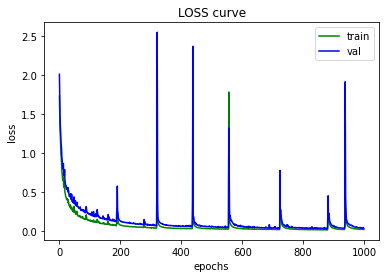

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:23
val size:8
test size:8
acc : t/v 0.4782608695652174 0.5
loss: t/v 1.7234962504843008 1.611593946814537
acc : t/v 0.4782608695652174 0.5
loss: t/v 1.480474871137868 1.4047504365444183
acc : t/v 0.4782608695652174 0.5
loss: t/v 1.337237228517947 1.284262865781784
acc : t/v 0.6086956521739131 0.625
loss: t/v 1.2281241883402285 1.1950261667370796
acc : t/v 0.6086956521739131 0.625
loss: t/v 1.1270106979038403 1.1030557975172997
acc : t/v 0.6956521739130435 0.75
loss: t/v 1.06920195662457 1.046144723892212
acc : t/v 0.7391304347826086 0.75
loss: t/v 0.9692335102869116 0.951183557510376
acc : t/v 0.7391304347826086 0.75
loss: t/v 0.9025133355804111 0.8964164331555367
acc : t/v 0.7391304347826086 0.75
loss: t/v 0.853077434975168 0.8519498407840729
acc : t/v 0.8695652173913043 0.875
loss: t/v 0.7811702813791193 0.7771451659500599
acc : t/v 0.8695652173913043 0.875
loss: t/v 0.735338340634885 0.7296588383615017
acc : t/v 0.8695652173913043 0.875
loss: t/v 0.6902185795099839 0.6935

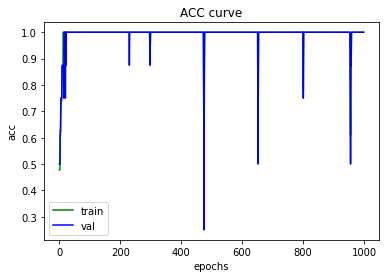

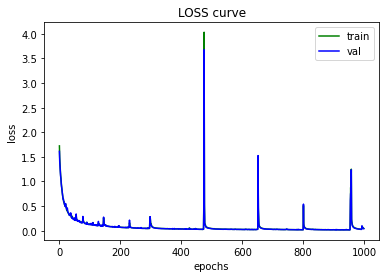

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:24
val size:8
test size:7
acc : t/v 0.5 0.5
loss: t/v 1.740946466724078 2.0950804501771927
acc : t/v 0.5 0.5
loss: t/v 1.4819839199384053 1.7543783783912659
acc : t/v 0.5 0.5
loss: t/v 1.3146172016859055 1.5513104349374771
acc : t/v 0.5833333333333334 0.5
loss: t/v 1.19995712240537 1.4318176209926605
acc : t/v 0.75 0.75
loss: t/v 1.0888683274388313 1.2905839905142784
acc : t/v 0.75 0.75
loss: t/v 0.9948236222068468 1.1835246831178665
acc : t/v 0.7083333333333334 0.625
loss: t/v 0.9319805800914764 1.1554592624306679
acc : t/v 0.75 0.75
loss: t/v 0.8545236239830653 1.0839596763253212
acc : t/v 0.7916666666666666 0.75
loss: t/v 0.791088896493117 1.0177918151021004
acc : t/v 0.9166666666666666 0.875
loss: t/v 0.7258190140128136 0.9217244014143944
acc : t/v 0.7916666666666666 0.75
loss: t/v 0.7437319892148176 0.974048875272274
acc : t/v 1.0 1.0
loss: t/v 0.6461880542337894 0.8557289615273476
acc : t/v 1.0 1.0
loss: t/v 0.6040550619363785 0.8240097537636757
acc : t/v 1.0 0.75
loss

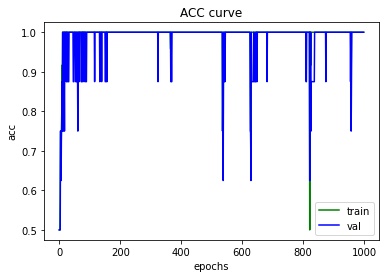

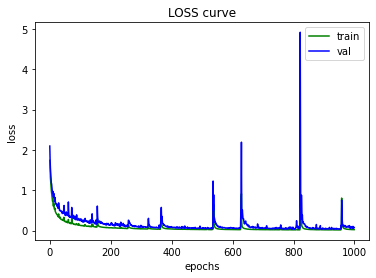

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:23
val size:8
test size:8
acc : t/v 0.4782608695652174 0.5
loss: t/v 1.6440175046091494 1.94857457280159
acc : t/v 0.4782608695652174 0.5
loss: t/v 1.4044983205587969 1.6328453570604324
acc : t/v 0.4782608695652174 0.5
loss: t/v 1.2692009495652241 1.4551715552806854
acc : t/v 0.6956521739130435 0.625
loss: t/v 1.19165155161982 1.3130985647439957
acc : t/v 0.6521739130434783 0.5
loss: t/v 1.0997041697087495 1.2476079910993576
acc : t/v 0.7391304347826086 0.75
loss: t/v 1.0621861297151316 1.162311851978302
acc : t/v 0.6956521739130435 0.5
loss: t/v 0.980161858641583 1.1595617532730103
acc : t/v 0.7391304347826086 0.625
loss: t/v 0.9045588892439137 1.0748501420021057
acc : t/v 0.7391304347826086 0.75
loss: t/v 0.8335036207800326 0.9820151329040527
acc : t/v 0.782608695652174 1.0
loss: t/v 0.7822139327940734 0.9225715920329094
acc : t/v 0.7391304347826086 0.75
loss: t/v 0.7608776934768843 0.9391287639737129
acc : t/v 0.7391304347826086 0.75
loss: t/v 0.7136492262715879 0.8372603

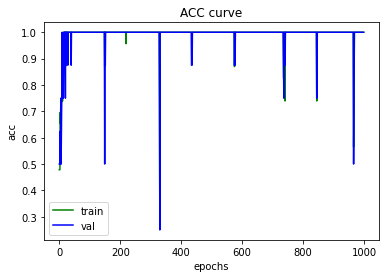

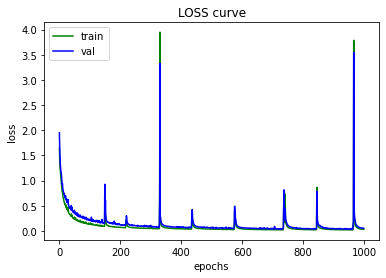

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

fold,iteration,macro,micro
3,0,0.8055555555555555,0.75
5,0,0.9333333333333332,0.875
1,0,0.8888888888888888,0.875
2,0,0.9166666666666666,0.8571428571428571
4,0,1.0,1.0
total,total,0.8799999999999999,0.851063829787234

      N    I     E
N  21.0  4.0   0.0
I   0.0  7.0   0.0
E   2.0  1.0  12.0


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [10]:
#Validation test
#(surgery_type,reg = 0.00001,summary=False,max_itr=1)
nb_epochs = 1000
surgery_type = 'Suturing' 
summary=False
reg =0.00001
max_itr=1
# reg is the regularization parameter 
# max_itr is the number of iterations to repeat the experiments
counter = 0
#UserOut & SuperTrialOut
path = path_to_configurations+surgery_type +'/'+'unBalanced'+'/'+'GestureClassification'+'/'+'SuperTrialOut'
results = "fold,iteration,macro,micro\n"
for it in range(0,max_itr):
  for subdir,dirs,files in os.walk(path):
    # One configuration with two files Train.txt and Test.txt
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    x_val = []
    y_val = []
    trial_added_to_val = None
    min_length_train = np.iinfo(np.int32).max # this is the minimum length of a training instance
    min_length_test = np.iinfo(np.int32).max # this is the minimum length of a test instance
    min_length_val = np.iinfo(np.int32).max # this is the minimum length of a val instance
    for file_name in files:
      data = readFile(subdir+'/'+file_name,str)
      surgeries_set = set()
      for gesture in data:
        surgery_name = find_pattern(gesture[0],surgery_type+'_.00.')
        surgeries_set.add(surgery_name)

      for surgery_name in surgeries_set:
        trial_num = get_trial_num(surgery_name,surgery_type)
        if file_name == 'Train.txt':
          if(trial_added_to_val is None):
            trial_added_to_val=trial_num
          
          if(trial_num==trial_added_to_val): 
            # we should add to validation set 
            min_length_val=min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_val)
            x_val.append(mapSurgeryDataBySurgeryName[surgery_name])
            y_val.append(mapExpertiseLevelBySurgeryName[surgery_name])
          else: # we add to the train set 
            min_length_train = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_train)
            x_train.append(mapSurgeryDataBySurgeryName[surgery_name])
            y_train.append(mapExpertiseLevelBySurgeryName[surgery_name])
        else:
          # we are adding to the test set
          min_length_test = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_test)
          x_test.append(mapSurgeryDataBySurgeryName[surgery_name])
          y_test.append(mapExpertiseLevelBySurgeryName[surgery_name])
      # end of one file Train or Test 
    if(len(files)>0):

      x_train = np.array(x_train)
      x_test = np.array(x_test)
      x_val = np.array(x_val)

      print('train size:'+str(len(x_train)))
      print('val size:'+str(len(x_val)))
      print('test size:'+str(len(x_test)))


      fit_encoder(y_train,y_test,y_val)

      model = each_dim_build_model(input_shapes,summary=summary,reg =reg)
      
      fold = find_pattern(subdir,'SuperTrialOut'+'/.*_Out').replace('SuperTrialOut'+'/','').replace('_Out','')
      iteration = find_pattern(subdir, 'itr_.*').replace('itr_','')
      # we train on each training instance 
        
      y_test, curve_acc, curve_loss = fitModel_curve(model,x_train,y_train,x_test,y_test,x_val,y_val)	
      #print(curve_acc)
      
      plt.plot(curve_acc[0], color = 'g', label='train')
      plt.plot(curve_acc[1], color = 'blue', label='val')
      plt.legend()
      plt.xlabel('epochs')
      plt.ylabel('acc')
      plt.title("ACC curve")
      plt.show()

      plt.plot( curve_loss[0], color = 'g', label='train')
      plt.plot( curve_loss[1], color = 'blue', label='val')
      plt.legend()
      plt.xlabel('epochs')
      plt.ylabel('loss')
      plt.title("LOSS curve")
      plt.show()
     
      model = load_model('LOSO/model.h5')# reload the best model saved 

      # uncomment if you want to visualize the class activiation map as a gif 
      # generate_class_activation_map_for_all_surgeries(model,fold)
      
      # evaluate model and get results for confusion matrix 
      (macro,micro) = evaluateModel(model,x_test,y_test)
      results += fold+','+str(it)+','+str(macro)+','+str(micro)+'\n'

    # end of one configuration 
matrix = confusion_matrix.to_numpy()
macro = compute_macro(matrix)
micro = compute_micro(matrix)
results += 'total,total,'+str(macro)+','+str(micro)+'\n'
results_file_name = 'results'
print(results)
print(confusion_matrix)

In [0]:
#time 
start_time = time.time()

# comment then uncommment the commented lines if you want to load a pre-trained model 

validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)

# model = load_model(path_to_results+'feedback/example-figure-in-paper/model.h5')

# encoder.classes_ = np.load(path_to_results+'feedback/example-figure-in-paper/binary_classes.npy')

# create_video_feedback(mapSurgeryDataBySurgeryName['Suturing_H004'],convertStringClassesToBinaryClasses(['N'],['N','I','E'],[])[0],model,'Suturing_H004',slave_manipulator='_Left_mod')

# uncomment to visualize the trajectory illustrated in the paper
# class_activation_map(mapSurgeryDataBySurgeryName['Suturing_H004'],convertStringClassesToBinaryClasses(['N'],['N','I','E'],[])[0],model,'Suturing_H004.pdf')

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

train size:23
val size:8
test size:8





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










ValueError: ignored